In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4-tf


In [0]:
tf.enable_eager_execution() #eager mode

In [0]:
learning_rate = 0.001
training_epochs = 30
batch_size = 100

tf.set_random_seed(777)

In [0]:
cifar = keras.datasets.cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
(train_images, train_labels), (test_images, test_labels) = cifar.load_data() #image는 (32, 32, 3)으로 되어있다.

train_images = train_images.astype(np.float32) / 255. #type이 int (0~255)로 되어있는 이미지를 0~1로 만들어준다.
test_images = test_images.astype(np.float32) / 255.

train_labels = to_categorical(train_labels, 10) #[50000, 1]이었던 레이블셋을 one_hot encoding으로 바꿔줌 (클래스가 10개이므로 [50000, 10]으로 바꿔준다.)
test_labels = to_categorical(test_labels, 10)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=100000).batch(batch_size) # 100000개 안에서 데이터를 셔플해주고 batch_size만큼의 batch를 만들어준다.
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)




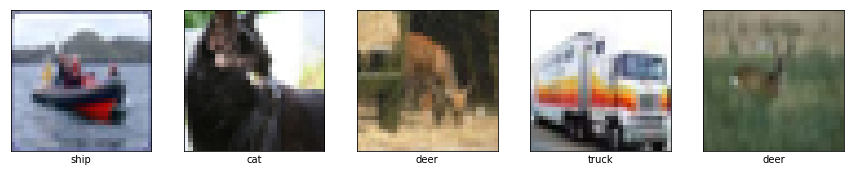

In [0]:
#Sample을 보여준다.
plt.figure(figsize=(15,15))
for i in range(5):
  img_idx = np.random.randint(0, 49999)
  plt.subplot(5, 5, i+1)
  plt.xticks([]) #x축 x값, 아무것도 리스트 안에 안쓰면 눈금이 안나온다.
  plt.yticks([]) #y축 y값
  plt.grid(False)
  plt.imshow(train_images[img_idx])
  plt.xlabel(class_names[np.argmax(train_labels[img_idx])])

In [0]:
def create_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', input_shape=(32, 32, 3)))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Flatten()) #N을 제외하고 3차원(N, W, H, C)인 output을 1차원(N, W x H x C)으로 만들어줌
  model.add(keras.layers.Dense(256, activation=tf.nn.relu))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Dense(10))
  return model

In [0]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxP

In [0]:
def loss_fn(model, images, labels):
  logits = model(images, training=True)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
  return loss

In [0]:
def grad(model, images, labels):
  with tf.GradientTape() as tape:
    loss = loss_fn(model, images, labels)
  return tape.gradient(loss, model.variables) #loss값과 모든 변수를 테잎에 쓴다.

In [0]:
def evaluate(model, images, labels):
  logits = model(images, training=False)
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return accuracy

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [0]:
for epoch in range(training_epochs):
  avg_loss = 0.
  avg_train_acc = 0.
  avg_test_acc = 0.
  train_step = 0
  test_step = 0
  
  for images, labels in train_dataset:
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.variables))
    loss = loss_fn(model, images, labels)
    acc = evaluate(model, images, labels)
    avg_loss = avg_loss + loss
    avg_train_acc = avg_train_acc + acc
    train_step += 1
  
  avg_loss = avg_loss / train_step
  avg_train_acc = avg_train_acc / train_step
  
  for images, labels in test_dataset:
    acc = evaluate(model, images, labels)
    avg_test_acc = avg_test_acc + acc
    test_step += 1
  
  avg_test_acc = avg_test_acc / test_step
  
  print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

Epoch: 1 loss = 1.55215728 train accuracy =  0.4621 test accuracy =  0.5489


KeyboardInterrupt: ignored